# Preparación de Silver para Análisis de Sentimientos (BERT)
**Autor:** Felipe Rosero — Tesis USFQ
Este script limpia `silver.parquet`, genera `texto_model`, detecta idioma,
hace un EDA mínimo (2 gráficos) y exporta un dataset listo para BERT
filtrado a {technology, artificial, futurology}.

# Instalación y versiones (seguro para Colab; en local puedes comentar la línea pip)

In [31]:
try:
    import pandas as pd, pyarrow  # noqa: F401
except Exception:
    import sys
    !{sys.executable} -m pip install -q pandas pyarrow langdetect tqdm matplotlib --upgrade

import os, re
import numpy as np
import pandas as pd
from dataclasses import dataclass, field
from typing import List
from langdetect import detect, DetectorFactory
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

print("pandas:", pd.__version__)

pandas: 2.3.2


# Configuración

In [32]:
DetectorFactory.seed = 42

@dataclass
class Config:
    INPUT_PARQUET: str = "../data/silver/silver.parquet"
    OUTPUT_DIR: str = "../outputs"
    OUT_ARTIFACTS: str = "../artifacts"

    COL_ID: str = "id"
    COL_TITULO: str = "titulo"
    COL_TEXTO: str = "texto"
    COL_TITULO_LIMPIO: str = "titulo_limpio"
    COL_TEXTO_LIMPIO: str = "texto_limpio"
    COL_SUB: str = "subreddit_nombre"
    COL_FECHA: str = "fecha_creacion_utc"

    TARGET_SUBS: List[str] = field(default_factory=lambda: ["technology","artificial","futurology"])
    MIN_LEN_TEXTO: int = 20
    ALLOW_LANGS: List[str] = field(default_factory=lambda: ["es","en"])

    KEEP_COLS: List[str] = field(default_factory=lambda: [
        "id","subreddit_nombre","fecha_creacion_utc",
        "titulo","texto","titulo_limpio","texto_limpio",
        "puntaje","total_comentarios","ratio_upvotes",
        "autor","autor_premium","autor_patreon",
        "es_adulto","es_spoiler","solo_media"
    ])
    DROP_COLS: List[str] = field(default_factory=lambda: [
        "miniatura","miniatura_alto","miniatura_ancho",
        "autor_flair_css","flair_css","autor_flair_richtext_json",
        "flair_richtext_json","media_json","media_segura_json",
        "media_embed_json","media_segura_embed_json","previsualizacion_json",
        "datos_galeria_json","metadatos_media_json","premiadores_json",
        "premiaciones_json","gildings_json","lista_republicaciones_json",
        "datos_encuesta_json","categorias_contenido_json","etiquetas_tratamiento_json",
        "raw_payload","extras","wls","pwls","estado_lista_blanca","estado_lista_blanca_padre"
    ])

    OUT_PARQUET_CLEAN: str = "silver_clean.parquet"
    OUT_PARQUET_READY: str = "silver_sentiment_ready.parquet"
    OUT_DIC: str = "diccionario_variables.csv"

cfg = Config()
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
cfg

Config(INPUT_PARQUET='../data/silver/silver.parquet', OUTPUT_DIR='../outputs', OUT_ARTIFACTS='../artifacts', COL_ID='id', COL_TITULO='titulo', COL_TEXTO='texto', COL_TITULO_LIMPIO='titulo_limpio', COL_TEXTO_LIMPIO='texto_limpio', COL_SUB='subreddit_nombre', COL_FECHA='fecha_creacion_utc', TARGET_SUBS=['technology', 'artificial', 'futurology'], MIN_LEN_TEXTO=20, ALLOW_LANGS=['es', 'en'], KEEP_COLS=['id', 'subreddit_nombre', 'fecha_creacion_utc', 'titulo', 'texto', 'titulo_limpio', 'texto_limpio', 'puntaje', 'total_comentarios', 'ratio_upvotes', 'autor', 'autor_premium', 'autor_patreon', 'es_adulto', 'es_spoiler', 'solo_media'], DROP_COLS=['miniatura', 'miniatura_alto', 'miniatura_ancho', 'autor_flair_css', 'flair_css', 'autor_flair_richtext_json', 'flair_richtext_json', 'media_json', 'media_segura_json', 'media_embed_json', 'media_segura_embed_json', 'previsualizacion_json', 'datos_galeria_json', 'metadatos_media_json', 'premiadores_json', 'premiaciones_json', 'gildings_json', 'lista_re

# Utilidades

In [33]:
URL_RE = re.compile(r"http\S+|www\.\S+")

def clean_basic(s: str) -> str:
    s = str(s) if s is not None else ""
    s = URL_RE.sub(" ", s)
    s = re.sub(r"[\r\n\t]+", " ", s)
    s = re.sub(r"\s{2,}", " ", s).strip()
    return s.lower()

def build_texto_model(row) -> str:
    t1 = row.get(cfg.COL_TITULO_LIMPIO) or clean_basic(row.get(cfg.COL_TITULO, ""))
    t2 = row.get(cfg.COL_TEXTO_LIMPIO) or clean_basic(row.get(cfg.COL_TEXTO, ""))
    if t1 and t2:
        return f"{t1}\n{t2}".strip()
    return (t1 or t2).strip()

def detect_lang_safe(s: str) -> str:
    try:
        return detect(s) if s else "unk"
    except Exception:
        return "unk"

def report(df: pd.DataFrame):
    print("Forma:", df.shape)
    print("Columnas:", len(df.columns))
    print("Top nulos:\n", df.isna().mean().sort_values(ascending=False).head(10))
    if cfg.COL_SUB in df.columns:
        print("Top subreddits:\n", df[cfg.COL_SUB].value_counts().head(10))
    if "texto_model" in df.columns:
        print("Longitud media texto:", df["texto_model"].str.len().mean())

def save_parquet(df: pd.DataFrame, path: str):
    df.to_parquet(path, index=False)

def save_csv(df: pd.DataFrame, path: str):
    df.to_csv(path, index=False)


# Carga de datos y diagnóstico inicial

In [34]:
df = pd.read_parquet(cfg.INPUT_PARQUET)

for c in [cfg.COL_ID, cfg.COL_SUB, cfg.COL_FECHA]:
    assert c in df.columns, f"Columna requerida ausente: {c}"
assert (
    (cfg.COL_TEXTO in df.columns) or (cfg.COL_TEXTO_LIMPIO in df.columns) or
    (cfg.COL_TITULO in df.columns) or (cfg.COL_TITULO_LIMPIO in df.columns)
), "No hay texto/título en el dataset"

report(df)

Forma: (717137, 88)
Columnas: 88
Top nulos:
 id                       0.0
titulo                   0.0
texto                    0.0
autor                    0.0
autor_nombre_completo    0.0
autor_premium            0.0
autor_patreon            0.0
autor_flair_texto        0.0
autor_flair_css          0.0
autor_flair_tipo         0.0
dtype: float64
Top subreddits:
 subreddit_nombre
politics      105009
worldnews     103478
technology    102759
technews      101551
Health        101409
Economics     101137
business      100977
science          500
artificial       112
Futurology       105
Name: count, dtype: int64


# Limpieza: construir texto_model, filtrar media, tipos, duplicados

In [35]:
df["texto_model"] = df.apply(build_texto_model, axis=1)
df["longitud_texto"] = df["texto_model"].str.len()

# filtrar media
if "solo_media" in df.columns:
    df = df[~df["solo_media"].fillna(False)]
for c in ["es_video","es_galeria"]:
    if c in df.columns:
        df = df[~df[c].fillna(False)]

# vacío y min len
df = df[df["texto_model"].fillna("") != ""]
df = df[df["longitud_texto"] >= cfg.MIN_LEN_TEXTO]

# duplicados
df.drop_duplicates(subset=[cfg.COL_ID], keep="first", inplace=True)

# fecha a datetime UTC
try:
    sec = pd.to_numeric(df["fecha_creacion_utc"], errors="coerce").astype("Int64")
    df["fecha_creacion_utc"] = pd.to_datetime(sec, unit="s", utc=True)
except Exception:
    pass
print(df["fecha_creacion_utc"].head(1))
report(df)


0   2025-08-26 05:06:21+00:00
Name: fecha_creacion_utc, dtype: datetime64[s, UTC]
Forma: (10913, 90)
Columnas: 90
Top nulos:
 id                       0.0
titulo                   0.0
texto                    0.0
autor                    0.0
autor_nombre_completo    0.0
autor_premium            0.0
autor_patreon            0.0
autor_flair_texto        0.0
autor_flair_css          0.0
autor_flair_tipo         0.0
dtype: float64
Top subreddits:
 subreddit_nombre
politics      4716
worldnews     2370
technology    1575
Economics      674
business       558
technews       321
Health         297
Futurology     105
artificial     104
science        100
Name: count, dtype: int64
Longitud media texto: 129.2212040685421


# Detección de idioma y filtro

In [36]:
tqdm.pandas(desc="Detectando idioma")
df["idioma_detectado"] = df["texto_model"].progress_apply(detect_lang_safe)
df = df[df["idioma_detectado"].isin(cfg.ALLOW_LANGS)]
report(df)

Detectando idioma: 100%|██████████| 10913/10913 [00:18<00:00, 586.02it/s]

Forma: (10560, 91)
Columnas: 91
Top nulos:
 id                       0.0
titulo                   0.0
texto                    0.0
autor                    0.0
autor_nombre_completo    0.0
autor_premium            0.0
autor_patreon            0.0
autor_flair_texto        0.0
autor_flair_css          0.0
autor_flair_tipo         0.0
dtype: float64
Top subreddits:
 subreddit_nombre
politics      4578
worldnews     2250
technology    1547
Economics      653
business       551
technews       315
Health         291
Futurology     103
artificial     102
science        100
Name: count, dtype: int64
Longitud media texto: 130.5159090909091


# Reducción de columnas (drop + keep + orden)

In [37]:
drop_exist = [c for c in cfg.DROP_COLS if c in df.columns]
df = df.drop(columns=drop_exist, errors="ignore")

keep_exist = [c for c in cfg.KEEP_COLS if c in df.columns]
ordered = keep_exist + [c for c in ["texto_model","idioma_detectado","longitud_texto"] if c in df.columns]
rest = [c for c in df.columns if c not in ordered]
df = df[ordered + rest]

report(df)

Forma: (10560, 64)
Columnas: 64
Top nulos:
 id                    0.0
subreddit_nombre      0.0
fecha_creacion_utc    0.0
titulo                0.0
texto                 0.0
titulo_limpio         0.0
texto_limpio          0.0
puntaje               0.0
total_comentarios     0.0
ratio_upvotes         0.0
dtype: float64
Top subreddits:
 subreddit_nombre
politics      4578
worldnews     2250
technology    1547
Economics      653
business       551
technews       315
Health         291
Futurology     103
artificial     102
science        100
Name: count, dtype: int64
Longitud media texto: 130.5159090909091


# EDA 1: Histograma de longitud de texto

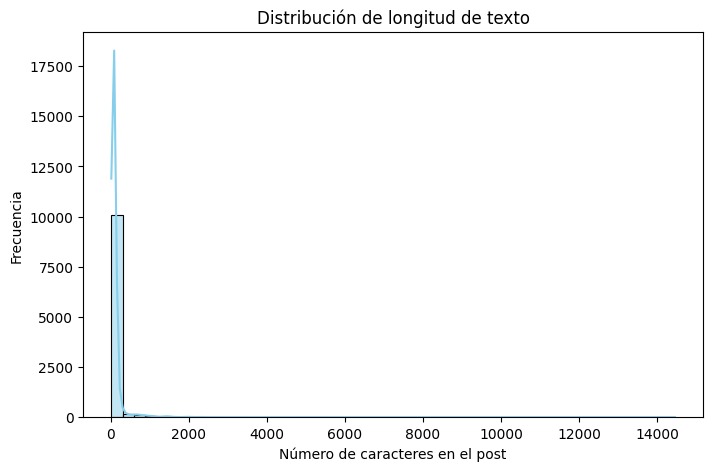

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df["longitud_texto"], bins=50, kde=True, color="skyblue")
plt.title("Distribución de longitud de texto")
plt.xlabel("Número de caracteres en el post")
plt.ylabel("Frecuencia")
plt.show()

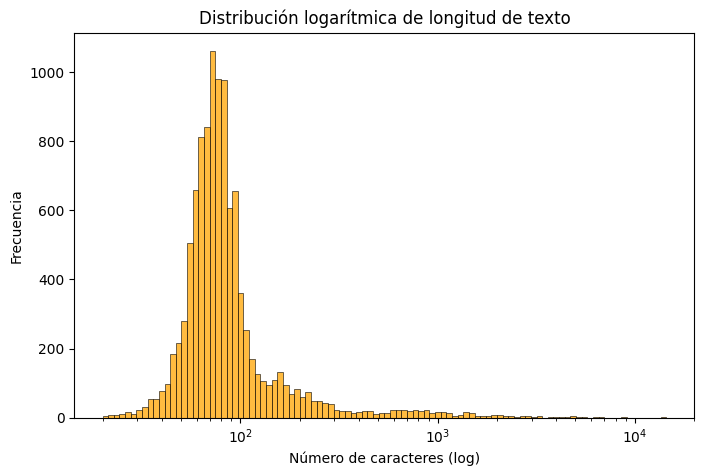

In [39]:
plt.figure(figsize=(8,5))
sns.histplot(df["longitud_texto"], bins=100, log_scale=True, color="orange")
plt.title("Distribución logarítmica de longitud de texto")
plt.xlabel("Número de caracteres (log)")
plt.ylabel("Frecuencia")
plt.show()

# EDA 2: Conteo por mes

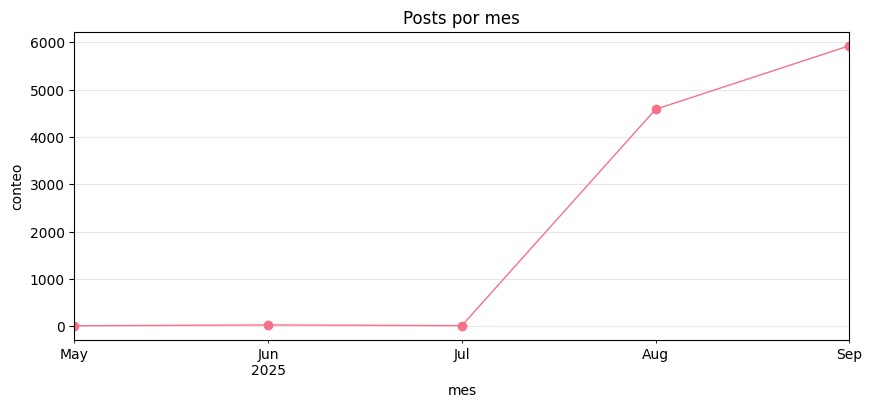

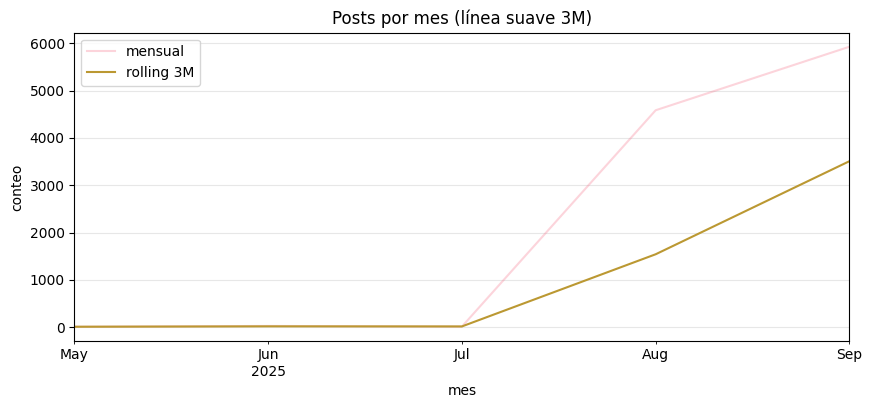

In [40]:
# Re-muestreo mensual (inicio de mes)
tmp = df.set_index("fecha_creacion_utc").resample("MS").size()

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
tmp.plot(marker="o", linewidth=1)
plt.title("Posts por mes")
plt.xlabel("mes")
plt.ylabel("conteo")
plt.grid(True, alpha=0.3)
plt.show()

# (opcional) Suavizado para ver tendencia
tmp_rolling = tmp.rolling(3, min_periods=1).mean()
plt.figure(figsize=(10,4))
tmp.plot(alpha=0.3)
tmp_rolling.plot()
plt.title("Posts por mes (línea suave 3M)")
plt.xlabel("mes")
plt.ylabel("conteo")
plt.legend(["mensual","rolling 3M"])
plt.grid(True, alpha=0.3)
plt.show()

# Análisis rápido de variables numéricas potencialmente informativas

In [41]:
num_cols = [c for c in ["puntaje","total_comentarios","ratio_upvotes","longitud_texto"] if c in df.columns]
desc = df[num_cols].describe().T if num_cols else pd.DataFrame()
print("Resumen numérico:\n", desc)
if len(num_cols) >= 2:
    print("Correlaciones de Spearman:\n", df[num_cols].corr(method="spearman"))

Resumen numérico:
                      count        mean          std    min    25%   50%  \
puntaje            10560.0  927.283712  3564.770435   0.00  11.00  64.0   
total_comentarios  10560.0   72.954451   208.442329   0.00   4.00  14.0   
ratio_upvotes      10560.0    0.822734     0.203054   0.02   0.77   0.9   
longitud_texto     10560.0  130.515909   340.252637  20.00  64.00  76.0   

                      75%      max  
puntaje            331.00  68488.0  
total_comentarios   50.00   3727.0  
ratio_upvotes        0.96      1.0  
longitud_texto      95.00  14452.0  
Correlaciones de Spearman:
                     puntaje  total_comentarios  ratio_upvotes  longitud_texto
puntaje            1.000000           0.709909       0.639761       -0.003131
total_comentarios  0.709909           1.000000       0.246628       -0.042755
ratio_upvotes      0.639761           0.246628       1.000000        0.071779
longitud_texto    -0.003131          -0.042755       0.071779        1.000000


Resumen numérico
	•	puntaje (upvotes – downvotes)
	•	Media ≈ 927, pero con desviación muy alta (3564).
	•	Mediana = 64 → significa que la mayoría de posts tienen pocos votos, pero hay outliers muy populares (hasta 68 k).
	•	total_comentarios
	•	Media ≈ 73, pero mediana = 14.
	•	Igual que con puntaje: la mayoría de posts tienen pocos comentarios, pero algunos alcanzan miles.
	•	ratio_upvotes
	•	Promedio ≈ 0.82 (es decir, 82 % de votos positivos).
	•	El 75 % de posts tiene ≥ 0.96 → hay un sesgo hacia contenidos con más votos positivos.
	•	longitud_texto
	•	Promedio ≈ 130 caracteres, mediana = 76.
	•	La mayoría son textos cortos, pero hay casos extremos de hasta 14 k caracteres (ensayos/largos hilos).

⸻

🔗 Correlaciones (Spearman)
	•	puntaje ↔ total_comentarios = 0.71 (alta)
→ Posts con más comentarios suelen tener más puntaje (lo esperado: popularidad general).
	•	puntaje ↔ ratio_upvotes = 0.64 (moderada-alta)
→ Posts con más votos positivos tienden a acumular más puntaje.
	•	total_comentarios ↔ ratio_upvotes = 0.25 (baja-moderada)
→ Algunos posts con discusiones largas no siempre tienen un ratio positivo tan alto (discusiones polémicas).
	•	longitud_texto casi no correlaciona
	•	Con puntaje: -0.003 (nula).
	•	Con comentarios: -0.04 (muy baja, casi nula).
	•	Con ratio_upvotes: 0.07 (casi nula).
→ La longitud del post no influye directamente en su popularidad o valoración.

⸻


# Exportar dataset limpio general (antes del filtro de IA)

In [42]:
path_clean = os.path.join(cfg.OUTPUT_DIR, cfg.OUT_PARQUET_CLEAN)
save_parquet(df, path_clean)
print("Guardado:", path_clean, df.shape)

Guardado: ../outputs/silver_clean.parquet (10560, 64)


# Filtro IA: subreddits objetivo

In [43]:
subs_obj = set([s.lower() for s in cfg.TARGET_SUBS])
present = set(df[cfg.COL_SUB].str.lower().unique()) if cfg.COL_SUB in df.columns else set()
encontrados = sorted(subs_obj & present)
faltantes = sorted(subs_obj - present)
print("Subreddits encontrados:", encontrados)
print("Subreddits faltantes:", faltantes)
df_target = df[df[cfg.COL_SUB].str.lower().isin(encontrados)] if encontrados else df.head(0).copy()
print("Tamaño df_target:", df_target.shape)

# Exportar dataset listo para BERT
path_ready = os.path.join(cfg.OUTPUT_DIR, cfg.OUT_PARQUET_READY)
save_parquet(df_target, path_ready)
print("Guardado:", path_ready, df_target.shape)

# Diccionario de variables del df_target
dic_rows = []
for c in df_target.columns:
    s = df_target[c]
    ex = s.dropna().astype(str).head(1).tolist()
    dic_rows.append({
        "columna": c,
        "dtype": str(s.dtype),
        "%_nulos": float(s.isna().mean()*100),
        "ejemplo": ex[0] if ex else ""
    })
dic_df = pd.DataFrame(dic_rows)
path_dic = os.path.join(cfg.OUTPUT_DIR, cfg.OUT_DIC)
save_csv(dic_df, path_dic)
print("Guardado diccionario:", path_dic, dic_df.shape)

Subreddits encontrados: ['artificial', 'futurology', 'technology']
Subreddits faltantes: []
Tamaño df_target: (1752, 64)
Guardado: ../outputs/silver_sentiment_ready.parquet (1752, 64)
Guardado diccionario: ../outputs/diccionario_variables.csv (64, 4)


# Etiquetado débil + splits + balance + truncamiento + export

In [44]:
try:
    import transformers, torch  
except Exception:
    !pip install -q transformers torch --upgrade

import os, json, math, numpy as np, pandas as pd, torch
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Usamos df_target si existe (subreddits IA), si no, df (limpio)

In [45]:
if "df_target" in globals() and isinstance(df_target, pd.DataFrame) and len(df_target):
    df_ready = df_target.copy()
else:
    df_ready = df.copy()

assert "texto_model" in df_ready.columns, "No encuentro 'texto_model' en el DataFrame."
assert "id" in df_ready.columns, "Se requiere columna 'id' para trazabilidad."

# 1) Etiquetado débil (modelo baseline multilingüe)

In [46]:
# ==== Baseline multilingüe estable para etiquetado débil (1-5 estrellas → neg/neu/pos) ====
import torch, numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

def pick_device():
    if torch.cuda.is_available(): return "cuda"
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available(): return "mps"
    return "cpu"

device_str = pick_device()
print("device:", device_str)

MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"  # 1..5 estrellas
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device_str).eval()

# Mapear índice de estrella (0..4) a etiqueta 3 clases
def _stars_to_label(star_idx: int):
    s = star_idx + 1  # 1..5
    if s in (1, 2): return "neg"
    if s == 3:       return "neu"
    return "pos"

# Mantengo la MISMA firma que tu pipeline usa: devuelve (label3, p_neg, p_neu, p_pos)
def predict_batch(texts, batch_size=64, max_length=256):
    rows = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tokenizer(batch, truncation=True, max_length=max_length,
                            padding=True, return_tensors="pt")
            if device_str in ("cuda","mps"):
                enc = {k: v.to(device_str) for k, v in enc.items()}
            logits = model(**enc).logits               # [B,5]
            probs  = torch.softmax(logits, dim=-1).cpu().numpy()
            stars  = probs.argmax(axis=-1)             # 0..4
            for p, y in zip(probs, stars):
                lab3  = _stars_to_label(int(y))
                p_neg = float(p[0] + p[1])             # 1-2 estrellas
                p_neu = float(p[2])                    # 3 estrellas
                p_pos = float(p[3] + p[4])             # 4-5 estrellas
                rows.append((lab3, p_neg, p_neu, p_pos))
    return rows

# Smoke test rápido
print("Smoke test →", predict_batch(["la ia me gusta", "no me convence", "meh"], batch_size=3))

device: cuda
Smoke test → [('pos', 0.07141229510307312, 0.24286100268363953, 0.6857267618179321), ('neg', 0.7511310577392578, 0.23114505410194397, 0.017723867669701576), ('neu', 0.501443088054657, 0.4562471807003021, 0.04230973869562149)]


# Deduplicación previa por 'texto_model' para no inferir duplicados exactos

In [47]:
before = len(df_ready)
df_ready = df_ready.drop_duplicates(subset=["texto_model"]).reset_index(drop=True)
print(f"Deduplicados por texto_model (antes de inferir): {before - len(df_ready)}")

Deduplicados por texto_model (antes de inferir): 36


# Inferencia débil (puedes limitar para pruebas: df_ready.head(2000))

In [48]:
preds = predict_batch(df_ready["texto_model"].tolist(), batch_size=64, max_length=256)
lab, pneg, pneu, ppos = zip(*preds)
df_ready["sentimiento_label"] = lab
df_ready["p_neg"] = pneg
df_ready["p_neu"] = pneu
df_ready["p_pos"] = ppos
print("Etiquetado débil completado. Distribución:")
print(df_ready["sentimiento_label"].value_counts(normalize=True).round(3))

Etiquetado débil completado. Distribución:
sentimiento_label
neg    0.546
pos    0.389
neu    0.065
Name: proportion, dtype: float64


# ---------- 2) Esquema de etiquetas y mapeos ----------

In [49]:

OUT_ARTIFACTS = Path(cfg.OUT_ARTIFACTS)
LABEL_MAP = {"neg":0, "neu":1, "pos":2}
with open(OUT_ARTIFACTS / "label_map.json", "w", encoding="utf-8") as f:
    json.dump(LABEL_MAP, f, ensure_ascii=False, indent=2)
print("Guardado mapeo de etiquetas en ../artifacts/label_map.json")

df_ready["label"] = df_ready["sentimiento_label"].map(LABEL_MAP).astype("Int64")

Guardado mapeo de etiquetas en ../artifacts/label_map.json


# 3) Particiones estratificadas (train/val/test)


In [50]:
from sklearn.model_selection import train_test_split
# Control: quitar posibles NA en label/texto
df_labeled = df_ready.dropna(subset=["texto_model","label"]).reset_index(drop=True)

# Split 80/10/10 estratificado
train_df, temp_df = train_test_split(
    df_labeled, test_size=0.2, stratify=df_labeled["label"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42
)

def dist(name, d):
    print(f"{name} size={len(d)} | dist:", d["label"].value_counts(normalize=True).sort_index().round(3).to_dict())

dist("train", train_df); dist("val", val_df); dist("test", test_df)

train size=1372 | dist: {np.int64(0): 0.546, np.int64(1): 0.065, np.int64(2): 0.389}
val size=172 | dist: {np.int64(0): 0.547, np.int64(1): 0.064, np.int64(2): 0.39}
test size=172 | dist: {np.int64(0): 0.547, np.int64(1): 0.064, np.int64(2): 0.39}


# 4) Balance de clases (class weights)

In [51]:
vc = train_df["label"].value_counts().sort_index()  # 0,1,2
class_weights = (1.0 / (vc / vc.sum())).values
# Normalizar para que la media sea ~1 (opcional)
class_weights = class_weights * (len(class_weights) / class_weights.sum())
print("Class weights (orden neg,neu,pos):", class_weights.round(3).tolist())

Class weights (orden neg,neu,pos): [0.277, 2.334, 0.389]


# 5) Longitud/tokenización y tasa de truncamiento

In [52]:
def token_lengths(texts, sample_n=20000, max_length=256):
    # muestreo para acelerar en datasets grandes
    if len(texts) > sample_n:
        texts = texts.sample(sample_n, random_state=42)
    enc = tokenizer(texts.tolist(), truncation=False, padding=False)
    lens = [len(x) for x in enc["input_ids"]]
    arr = np.array(lens)
    trunc_rate = float((arr > max_length).mean())
    stats = {
        "mean_tokens": float(arr.mean()),
        "p50": int(np.percentile(arr, 50)),
        "p90": int(np.percentile(arr, 90)),
        "p95": int(np.percentile(arr, 95)),
        "p99": int(np.percentile(arr, 99)),
        "max": int(arr.max()),
        "trunc_rate_at_max_length": trunc_rate,
    }
    return stats

MAX_LENGTH = 256  # ajustable
len_stats = token_lengths(train_df["texto_model"], max_length=MAX_LENGTH)
print("Stats de tokens (train):", len_stats)

Token indices sequence length is longer than the specified maximum sequence length for this model (675 > 512). Running this sequence through the model will result in indexing errors


Stats de tokens (train): {'mean_tokens': 38.63192419825073, 'p50': 20, 'p90': 48, 'p95': 79, 'p99': 413, 'max': 1824, 'trunc_rate_at_max_length': 0.02040816326530612}


# 6) Control de calidad adicional

In [53]:
# - Filtrar outliers de longitud extrema (p99.9 de caracteres)
q_hi = df_labeled["longitud_texto"].quantile(0.999) if "longitud_texto" in df_labeled.columns else None
if q_hi is not None:
    n_before = len(df_labeled)
    df_labeled = df_labeled[df_labeled["longitud_texto"].between(20, q_hi)]
    print(f"Removidos outliers por longitud: {n_before - len(df_labeled)}")

# (Opcional) reforzar filtro de idioma si existe
if "idioma_detectado" in df_labeled.columns:
    keep_langs = {"es","en"}
    n_before = len(df_labeled)
    df_labeled = df_labeled[df_labeled["idioma_detectado"].isin(keep_langs)]
    print(f"Filtrados por idioma a {keep_langs}: {n_before - len(df_labeled)} removidos")


Removidos outliers por longitud: 2
Filtrados por idioma a {'en', 'es'}: 0 removidos


# 7) Guardar dataset final

In [54]:
OUT_DATA = Path("../data/silver")
OUT_DATA.mkdir(parents=True, exist_ok=True)
final_path = OUT_DATA / "silver_sentimiento_IA.parquet"

In [55]:
# Orden sugerido para entrenamiento + metadatos útiles
cols_first = ["id","subreddit_nombre","fecha_creacion_utc","texto_model","sentimiento_label","label","p_neg","p_neu","p_pos"]
cols_exist = [c for c in cols_first if c in df_labeled.columns]
df_final = pd.concat([df_labeled[cols_exist], df_labeled.drop(columns=[c for c in cols_exist if c in df_labeled.columns])], axis=1)

df_final.to_parquet(final_path, index=False)
print(f"Dataset final guardado en: {final_path}  | filas={len(df_final)}  | cols={len(df_final.columns)}")


Dataset final guardado en: ../data/silver/silver_sentimiento_IA.parquet  | filas=1714  | cols=69


In [56]:
# ---------- Checklist de entrenamiento ----------
print("\n================ CHECKLIST ENTRENAMIENTO ================")
print(f"- Dataset: {final_path.name} (filas={len(df_final)})")
print("- Etiquetas: neg=0, neu=1, pos=2  (guardado en ../artifacts/label_map.json)")
print(f"- Splits: train={len(train_df)}, val={len(val_df)}, test={len(test_df)} (estratificados)")
print(f"- Class weights (usar en CrossEntropyLoss, en orden [neg, neu, pos]): {class_weights.round(3).tolist()}")
print(f"- MAX_LENGTH={MAX_LENGTH} → tasa de truncamiento (train): {len_stats['trunc_rate_at_max_length']:.3f}")
print("- Deduplicación por texto aplicada antes del etiquetado débil")
print("- Outliers de longitud filtrados (p99.9) y verificación de idioma (es/en)")
print("- Recomendado en Lightning:")
print("    - LR=2e-5, batch=16, epochs=3, precision=16-mixed, early stopping en val_f1_macro")
print("    - Métricas: accuracy, F1 macro; guardar mejor checkpoint por F1 macro")
print("==========================================================")


================ CHECKLIST ENTRENAMIENTO ================
- Dataset: silver_sentimiento_IA.parquet (filas=1714)
- Etiquetas: neg=0, neu=1, pos=2  (guardado en ../artifacts/label_map.json)
- Splits: train=1372, val=172, test=172 (estratificados)
- Class weights (usar en CrossEntropyLoss, en orden [neg, neu, pos]): [0.277, 2.334, 0.389]
- MAX_LENGTH=256 → tasa de truncamiento (train): 0.020
- Deduplicación por texto aplicada antes del etiquetado débil
- Outliers de longitud filtrados (p99.9) y verificación de idioma (es/en)
- Recomendado en Lightning:
    - LR=2e-5, batch=16, epochs=3, precision=16-mixed, early stopping en val_f1_macro
    - Métricas: accuracy, F1 macro; guardar mejor checkpoint por F1 macro


# Confianza mínima y re-splits

In [57]:
# ============================================================
# Re-minado de NEUTRALES desde baja confianza + splits 3 clases
# ============================================================
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import json

DATA_ALL = Path("../data/silver/silver_sentimiento_IA.parquet")
PEND_LO  = Path("../data/silver/para_revision_baja_confianza.parquet")  # generado antes
OUT_DIR  = Path("../data/silver"); OUT_DIR.mkdir(parents=True, exist_ok=True)
ART_DIR  = Path("../artifacts");   ART_DIR.mkdir(parents=True, exist_ok=True)

# Objetivo mínimo de neutrales para que el stratify sea estable (ajusta si quieres)
TARGET_NEU_MIN = 60  # ~ garantiza al menos 6 en val y test y buen entrenamiento
TEST_SIZE      = 0.2
VAL_FROM_TEMP  = 0.5
RANDOM_STATE   = 42
EPS            = 1e-6

# 1) Cargar datasets
df_all = pd.read_parquet(DATA_ALL)
if PEND_LO.exists():
    df_lo = pd.read_parquet(PEND_LO)
else:
    # reconstruir "baja confianza" como complemento (por si faltara el archivo)
    assert {"p_neg","p_neu","p_pos","sentimiento_label"}.issubset(df_all.columns)
    conf = df_all[["p_neg","p_neu","p_pos"]].max(axis=1)
    # umbral de tu última corrida (aprox): neg/pos 0.60; neu 0.45
    mask_hi = (
        ((df_all["sentimiento_label"]=="neg") & (df_all["p_neg"]>=0.60)) |
        ((df_all["sentimiento_label"]=="pos") & (df_all["p_pos"]>=0.60)) |
        ((df_all["sentimiento_label"]=="neu") & (df_all["p_neu"]>=0.45))
    )
    df_lo = df_all[~mask_hi].copy()

# 2) Reconstruir df_hi como alta confianza con los umbrales previos
df_hi = df_all[
    ((df_all["sentimiento_label"]=="neg") & (df_all["p_neg"]>=0.60)) |
    ((df_all["sentimiento_label"]=="pos") & (df_all["p_pos"]>=0.60)) |
    ((df_all["sentimiento_label"]=="neu") & (df_all["p_neu"]>=0.45))
].copy()

def dist(d):
    return d["label"].value_counts(normalize=True).sort_index().round(3).to_dict()

print(f"Alta conf (antes de minado): {len(df_hi)} | dist:", dist(df_hi))

# 3) Si neutrales son escasos, re-minar desde baja confianza por p_neu descendente
current_neu = int((df_hi["label"]==1).sum())
if current_neu < TARGET_NEU_MIN:
    need = TARGET_NEU_MIN - current_neu
    print(f"🔎 Neutrales insuficientes ({current_neu}); minando {need} desde baja confianza…")

    # Candidatos neutrales en baja confianza:
    # prioridad: mayor p_neu y margen neutro razonable frente a otras clases
    cand = df_lo[df_lo["sentimiento_label"]=="neu"].copy()
    if len(cand) == 0:
        print("No hay candidatos neutrales en baja confianza. No se añaden neutrales.")
    else:
        cand["margin_neu"] = cand["p_neu"] - cand[["p_neg","p_pos"]].max(axis=1)
        # ordenar por p_neu y margen
        cand = cand.sort_values(["p_neu","margin_neu"], ascending=False)
        pick = cand.head(need)
        # unir a df_hi, evitando duplicados por id
        before = len(df_hi)
        df_hi = pd.concat([df_hi, pick], axis=0).drop_duplicates(subset=["id"]).reset_index(drop=True)
        print(f"➕ Añadidos neutrales: {len(df_hi)-before} | neutrales totales ahora: {(df_hi['label']==1).sum()}")

# 4) Si todavía faltan neutrales, relajar p_neu escalonadamente
current_neu = int((df_hi["label"]==1).sum())
if current_neu < TARGET_NEU_MIN:
    for th in [0.44, 0.43, 0.42, 0.41, 0.40, 0.39, 0.38]:
        need = TARGET_NEU_MIN - current_neu
        if need <= 0: break
        extra = df_all[
            (df_all["sentimiento_label"]=="neu") &
            (df_all["p_neu"]>=th)
        ].copy().sort_values("p_neu", ascending=False)
        # quitar los que ya están
        extra = extra[~extra["id"].isin(df_hi["id"])]
        if len(extra) == 0: continue
        add = extra.head(need)
        before = len(df_hi)
        df_hi = pd.concat([df_hi, add], axis=0).drop_duplicates(subset=["id"]).reset_index(drop=True)
        current_neu = int((df_hi["label"]==1).sum())
        print(f"→ Relajado TH_NEU={th:.2f} | neutrales={current_neu}")
        if current_neu >= TARGET_NEU_MIN: break

print(f"Alta conf (después de minado): {len(df_hi)} | dist:", dist(df_hi))

# 5) Comprobar clases presentes
present = sorted(df_hi["label"].unique().tolist())
if len(present) < 2:
    raise RuntimeError("No hay suficientes clases para entrenar. Revisa los umbrales.")
# Si siguen 3 clases pero neu muy rara (<2 ejemplos), caeremos a binario para garantizar estabilidad
min_per_class = df_hi["label"].value_counts().min()
if len(present)==3 and min_per_class < 2:
    print("⚠️ Aún hay clase con <2 muestras. Pasando a binario (neg vs pos) para entrenamiento estable.")
    df_hi = df_hi[df_hi["label"].isin([0,2])].copy()
    present = sorted(df_hi["label"].unique().tolist())

print("Clases presentes para split:", present)

# 6) Split estratificado; si falla, fallback sin estratify (muy poco probable ya)
def safe_splits(df, stratify=True):
    if stratify:
        try:
            tr, tmp = train_test_split(df, test_size=TEST_SIZE, stratify=df["label"], random_state=RANDOM_STATE)
            va, te = train_test_split(tmp, test_size=VAL_FROM_TEMP, stratify=tmp["label"], random_state=RANDOM_STATE)
            return tr, va, te, True
        except Exception as e:
            print("⚠️ Stratify falló:", repr(e))
    tr, tmp = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    va, te = train_test_split(tmp, test_size=VAL_FROM_TEMP, random_state=RANDOM_STATE)
    return tr, va, te, False

train_df, val_df, test_df, used_stratify = safe_splits(df_hi, stratify=True)

def pr(name, d):
    vc = d["label"].value_counts(normalize=True).sort_index().round(3).to_dict()
    print(f"{name}: {len(d)} | {vc}")
pr("train", train_df); pr("val", val_df); pr("test", test_df)
print("Stratify usado:", used_stratify)

# 7) Guardar splits y recalcular class_weights en el orden de 'present'
train_path = OUT_DIR/"train.parquet"
val_path   = OUT_DIR/"val.parquet"
test_path  = OUT_DIR/"test.parquet"
train_df.to_parquet(train_path, index=False)
val_df.to_parquet(val_path, index=False)
test_df.to_parquet(test_path, index=False)

vc_train = train_df["label"].value_counts().sort_index()
labels_present = vc_train.index.tolist()
freq = (vc_train / vc_train.sum()).values
inv = 1.0 / np.maximum(freq, EPS)
class_weights = inv * (len(inv)/inv.sum())

with open(ART_DIR/"class_weights.json", "w") as f:
    json.dump({
        "labels_present": labels_present,
        "class_weights": {str(i): float(w) for i, w in enumerate(class_weights)},
        "used_stratify": bool(used_stratify),
        "target_neu_min": int(TARGET_NEU_MIN)
    }, f, indent=2)

print("⚖️ Class weights:", np.round(class_weights, 3).tolist(), "| labels_present:", labels_present)
print("💾 Guardados splits en ../data/silver y pesos en ../artifacts/class_weights.json")

Alta conf (antes de minado): 1160 | dist: {np.int64(0): 0.606, np.int64(1): 0.003, np.int64(2): 0.391}
🔎 Neutrales insuficientes (4); minando 56 desde baja confianza…
➕ Añadidos neutrales: 56 | neutrales totales ahora: 60
Alta conf (después de minado): 1216 | dist: {np.int64(0): 0.578, np.int64(1): 0.049, np.int64(2): 0.373}
Clases presentes para split: [0, 1, 2]
train: 972 | {np.int64(0): 0.578, np.int64(1): 0.049, np.int64(2): 0.372}
val: 122 | {np.int64(0): 0.574, np.int64(1): 0.049, np.int64(2): 0.377}
test: 122 | {np.int64(0): 0.582, np.int64(1): 0.049, np.int64(2): 0.369}
Stratify usado: True
⚖️ Class weights: [0.21, 2.463, 0.327] | labels_present: [0, 1, 2]
💾 Guardados splits en ../data/silver y pesos en ../artifacts/class_weights.json


splits quedaron bien balanceados y estratificados con las 3 clases presentes:
	•	train/val/test con ~5% neutrales en cada split ✅
	•	Stratify usado: True ✅
	•	class_weights = [0.21, 2.463, 0.327] en orden [neg, neu, pos] (peso alto para neutral, como era de esperar) ✅

In [58]:
# ============================================================
# BERT (XLM-R) Sentimiento IA
# ============================================================

import os, gc, json, math, random, importlib, warnings
from pathlib import Path
from types import SimpleNamespace
import time
from datetime import datetime

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)

from sklearn.metrics import classification_report, confusion_matrix
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score

import matplotlib.pyplot as plt
import seaborn as sns

# Configurar warnings y style
warnings.filterwarnings('ignore', category=UserWarning)
plt.style.use('default')
sns.set_palette("husl")

# -------------------
# Semillas reproducibles
# -------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

# -------------------
# Silencios y env
# -------------------
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_SILENT"] = "true"

print("INICIANDO ENTRENAMIENTO DE MODELO DE SENTIMIENTOS")
print("=" * 60)

# ============================================================
# (1) Detección inteligente de dispositivo
# ============================================================
def detect_optimal_device():
    """Detecta el mejor dispositivo disponible y configuraciones óptimas"""
    device_info = {
        'device': None,
        'accelerator': None,
        'precision': None,
        'name': None
    }
    
    if torch.cuda.is_available():
        device_info['device'] = torch.device("cuda")
        device_info['accelerator'] = "gpu"
        device_info['name'] = torch.cuda.get_device_name(0)
        
        # Detectar soporte para bfloat16
        if hasattr(torch.cuda, 'is_bf16_supported') and torch.cuda.is_bf16_supported():
            device_info['precision'] = "bf16-mixed"
        else:
            device_info['precision'] = "16-mixed"
            
        try:
            torch.set_float32_matmul_precision("high")
            torch.backends.cudnn.benchmark = True
        except Exception:
            pass
            
        print(f"CUDA disponible: {device_info['name']}")
        print(f"   Precisión: {device_info['precision']}")
        print(f"   VRAM disponible: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
        
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device_info['device'] = torch.device("mps")
        device_info['accelerator'] = "mps"
        device_info['precision'] = 32
        device_info['name'] = "Apple Silicon MPS"
        print("MPS disponible (Apple Silicon)")
        
    else:
        device_info['device'] = torch.device("cpu")
        device_info['accelerator'] = "cpu"
        device_info['precision'] = 32
        device_info['name'] = "CPU"
        print("Usando CPU")
        
    return device_info

DEVICE_INFO = detect_optimal_device()

# ============================================================
# (2) Configuración avanzada
# ============================================================
CFG = SimpleNamespace(
    # Rutas
    DATA_DIR=Path("../data/silver"),
    TRAIN_PATH=Path("../data/silver/train.parquet"),
    VAL_PATH=Path("../data/silver/val.parquet"),
    TEST_PATH=Path("../data/silver/test.parquet"),
    ARTIFACTS_DIR=Path("../artifacts"),
    CKPT_DIR=Path("../artifacts/checkpoints"),
    PLOTS_DIR=Path("../artifacts/plots"),
    
    # Modelo
    MODEL_NAME="xlm-roberta-base",
    NUM_LABELS=3,
    MAX_LEN=256,
    
    # Entrenamiento
    BATCH_SIZE=32,
    GRAD_ACCUM=1,
    EPOCHS=3,
    LR=2e-5,
    WEIGHT_DECAY=0.01,
    WARMUP_PCT=0.06,
    NUM_WORKERS=4 if DEVICE_INFO['accelerator'] == 'gpu' else 0,
    
    # Monitoreo
    LOG_EVERY_N_STEPS=10,
    VAL_CHECK_INTERVAL=0.5,
    
    # Hardware
    **DEVICE_INFO
)

# Crear directorios
for dir_path in [CFG.ARTIFACTS_DIR, CFG.CKPT_DIR, CFG.PLOTS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

print(f"Directorios creados: checkpoints, plots")

# ============================================================
# (3) Cargar y validar datos
# ============================================================
def load_and_validate_data():
    """Carga y valida los datos de entrenamiento"""
    print("\nCARGANDO DATOS...")
    
    # Verificar archivos
    for name, path in [("train", CFG.TRAIN_PATH), ("val", CFG.VAL_PATH), ("test", CFG.TEST_PATH)]:
        if not path.exists():
            raise FileNotFoundError(f"No se encuentra {name}.parquet en {path}")
    
    # Cargar datos
    train_df = pd.read_parquet(CFG.TRAIN_PATH)
    val_df = pd.read_parquet(CFG.VAL_PATH)
    test_df = pd.read_parquet(CFG.TEST_PATH)
    
    # Detectar columna de texto
    text_cols = ["texto_model", "texto_limpio", "texto", "titulo_limpio", "titulo"]
    TEXT_COL = None
    for col in text_cols:
        if col in train_df.columns:
            TEXT_COL = col
            break
    
    if TEXT_COL is None:
        raise ValueError(f"No se encontró columna de texto. Buscadas: {text_cols}")
    
    if "label" not in train_df.columns:
        raise ValueError("El dataset debe tener columna 'label' numérica")
    
    # Estadísticas
    total_samples = len(train_df) + len(val_df) + len(test_df)
    
    print(f"Datos cargados exitosamente:")
    print(f"   Columna de texto: '{TEXT_COL}'")
    print(f"   Total muestras: {total_samples:,}")
    print(f"   Train: {len(train_df):,} ({len(train_df)/total_samples*100:.1f}%)")
    print(f"   Val: {len(val_df):,} ({len(val_df)/total_samples*100:.1f}%)")
    print(f"   Test: {len(test_df):,} ({len(test_df)/total_samples*100:.1f}%)")
    
    # Distribución de clases
    print(f"\nDistribución de clases (train):")
    class_dist = train_df['label'].value_counts().sort_index()
    class_names = ['Negativo', 'Neutro', 'Positivo']
    for i, (count, name) in enumerate(zip(class_dist.values, class_names)):
        pct = count / len(train_df) * 100
        print(f"   {i}: {name}: {count:,} ({pct:.1f}%)")
    
    return train_df, val_df, test_df, TEXT_COL

train_df, val_df, test_df, TEXT_COL = load_and_validate_data()

# ============================================================
# (4) Inicialización del modelo y tokenizer
# ============================================================
def setup_model_components():
    """Configura tokenizer, config y modelo"""
    print("\nCONFIGURANDO COMPONENTES DEL MODELO...")
    
    # Tokenizer con fallback
    def load_tokenizer(model_name):
        try:
            return AutoTokenizer.from_pretrained(model_name, use_fast=True)
        except Exception as e:
            print(f"Tokenizer rápido falló: {e}")
            return AutoTokenizer.from_pretrained(model_name, use_fast=False)
    
    tokenizer = load_tokenizer(CFG.MODEL_NAME)
    
    # Configuración del modelo
    hf_config = AutoConfig.from_pretrained(
        CFG.MODEL_NAME,
        num_labels=CFG.NUM_LABELS
    )
    
    # Función para construir modelo
    def build_hf_model():
        model = AutoModelForSequenceClassification.from_pretrained(
            CFG.MODEL_NAME, config=hf_config
        )
        
        # Optimizaciones de memoria
        if hasattr(model.config, "use_cache"):
            model.config.use_cache = False
            
        try:
            model.gradient_checkpointing_enable()
            print("Gradient checkpointing habilitado")
        except Exception as e:
            print(f"Gradient checkpointing no disponible: {e}")
            
        return model
    
    print(f"Modelo configurado: {CFG.MODEL_NAME}")
    print(f"   Vocabulario: {len(tokenizer):,} tokens")
    print(f"   Clases: {CFG.NUM_LABELS}")
    
    return tokenizer, hf_config, build_hf_model

tokenizer, hf_config, build_hf_model = setup_model_components()

# ============================================================
# (5) Dataset y DataModule optimizados
# ============================================================
class SentDataset(Dataset):
    def __init__(self, df, text_col=TEXT_COL, label_col="label"):
        self.texts = df[text_col].astype(str).tolist()
        self.labels = df[label_col].astype(int).tolist()
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

def collate_fn(batch):
    texts, labels = list(zip(*batch))
    enc = tokenizer(
        list(texts),
        truncation=True,
        max_length=CFG.MAX_LEN,
        padding=True,
        return_tensors="pt"
    )
    return enc, torch.tensor(labels, dtype=torch.long)

class SentimentDataModule(pl.LightningDataModule):
    def __init__(self, train_df, val_df, test_df):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
    def setup(self, stage=None):
        self.train_dataset = SentDataset(self.train_df)
        self.val_dataset = SentDataset(self.val_df)
        self.test_dataset = SentDataset(self.test_df)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=CFG.BATCH_SIZE,
            shuffle=True,
            num_workers=CFG.NUM_WORKERS,
            collate_fn=collate_fn,
            pin_memory=(CFG.accelerator == "gpu"),
            persistent_workers=(CFG.NUM_WORKERS > 0)
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=CFG.BATCH_SIZE * 2,  # Batch más grande para validación
            shuffle=False,
            num_workers=CFG.NUM_WORKERS,
            collate_fn=collate_fn,
            pin_memory=(CFG.accelerator == "gpu"),
            persistent_workers=(CFG.NUM_WORKERS > 0)
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=CFG.BATCH_SIZE * 2,
            shuffle=False,
            num_workers=CFG.NUM_WORKERS,
            collate_fn=collate_fn,
            pin_memory=(CFG.accelerator == "gpu"),
            persistent_workers=(CFG.NUM_WORKERS > 0)
        )

dm = SentimentDataModule(train_df, val_df, test_df)

# ============================================================
# (6) Cálculo y carga de pesos por clase
# ============================================================
def setup_class_weights():
    """Configura los pesos por clase para balancear el dataset"""
    print("\nCONFIGURANDO PESOS POR CLASE...")
    
    CLASS_WEIGHTS_PATH = CFG.ARTIFACTS_DIR / "class_weights.json"
    
    if CLASS_WEIGHTS_PATH.exists():
        with open(CLASS_WEIGHTS_PATH, "r") as f:
            cw_data = json.load(f)
        
        if isinstance(cw_data, dict) and "class_weights" in cw_data:
            cw_dict = cw_data["class_weights"]
        else:
            cw_dict = cw_data
        
        if isinstance(cw_dict, list):
            class_weights = torch.tensor(cw_dict, dtype=torch.float)
        else:
            class_weights = torch.tensor([
                float(cw_dict.get(str(i), 1.0)) for i in range(CFG.NUM_LABELS)
            ], dtype=torch.float)
        
        print("Pesos cargados desde archivo")
    else:
        # Calcular pesos inversos
        vc = train_df["label"].value_counts().sort_index()
        freq = vc / len(train_df)
        weights = 1.0 / freq
        weights = weights / weights.sum() * CFG.NUM_LABELS
        class_weights = torch.tensor(weights.values, dtype=torch.float)
        
        # Guardar para futuro uso
        with open(CLASS_WEIGHTS_PATH, "w") as f:
            json.dump({
                "labels_present": list(vc.index),
                "class_weights": {str(i): float(w) for i, w in enumerate(class_weights.tolist())},
                "computed_at": datetime.now().isoformat()
            }, f, indent=2)
        
        print("Pesos calculados y guardados")
    
    print(f"   Pesos finales: {[round(float(w), 3) for w in class_weights.tolist()]}")
    return class_weights

CLASS_WEIGHTS = setup_class_weights()

# ============================================================
# (7) LightningModule mejorado con métricas avanzadas
# ============================================================
class SentimentClassifier(pl.LightningModule):
    def __init__(self, model_name=CFG.MODEL_NAME, num_labels=CFG.NUM_LABELS, 
                 lr=CFG.LR, weight_decay=CFG.WEIGHT_DECAY, warmup_pct=CFG.WARMUP_PCT, 
                 class_weights=None):
        super().__init__()
        self.save_hyperparameters(ignore=["class_weights"])
        
        self.model = build_hf_model()
        self.lr = lr
        self.weight_decay = weight_decay
        self.warmup_pct = warmup_pct
        
        # Loss con pesos
        self.class_weights = class_weights if class_weights is not None else torch.ones(num_labels)
        self.loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        
        # Métricas
        self.train_acc = MulticlassAccuracy(num_classes=num_labels, average="macro")
        self.train_f1_macro = MulticlassF1Score(num_classes=num_labels, average="macro")
        self.train_f1_weighted = MulticlassF1Score(num_classes=num_labels, average="weighted")
        
        self.val_acc = MulticlassAccuracy(num_classes=num_labels, average="macro")
        self.val_f1_macro = MulticlassF1Score(num_classes=num_labels, average="macro")
        self.val_f1_weighted = MulticlassF1Score(num_classes=num_labels, average="weighted")
        
        self.test_acc = MulticlassAccuracy(num_classes=num_labels, average="macro")
        self.test_f1_macro = MulticlassF1Score(num_classes=num_labels, average="macro")
        self.test_f1_weighted = MulticlassF1Score(num_classes=num_labels, average="weighted")
        
        # Para guardar métricas por época
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []
        
    def forward(self, **inputs):
        return self.model(**inputs)
    
    def _shared_step(self, batch, stage):
        inputs, labels = batch
        outputs = self(**inputs)
        logits = outputs.logits
        
        loss = self.loss_fn(logits, labels)
        preds = torch.argmax(logits, dim=1)
        
        # Seleccionar métricas según el stage
        if stage == "train":
            acc = self.train_acc(preds, labels)
            f1_macro = self.train_f1_macro(preds, labels)
            f1_weighted = self.train_f1_weighted(preds, labels)
        elif stage == "val":
            acc = self.val_acc(preds, labels)
            f1_macro = self.val_f1_macro(preds, labels)
            f1_weighted = self.val_f1_weighted(preds, labels)
        else:  # test
            acc = self.test_acc(preds, labels)
            f1_macro = self.test_f1_macro(preds, labels)
            f1_weighted = self.test_f1_weighted(preds, labels)
        
        # Logging
        self.log(f"{stage}_loss", loss, prog_bar=True, on_step=(stage=="train"), on_epoch=True)
        self.log(f"{stage}_acc", acc, prog_bar=True, on_step=False, on_epoch=True)
        self.log(f"{stage}_f1_macro", f1_macro, prog_bar=(stage=="val"), on_step=False, on_epoch=True)
        self.log(f"{stage}_f1_weighted", f1_weighted, prog_bar=False, on_step=False, on_epoch=True)
        
        return {
            'loss': loss,
            'preds': preds.detach(),
            'labels': labels.detach(),
            'logits': logits.detach()
        }
    
    def training_step(self, batch, batch_idx):
        result = self._shared_step(batch, "train")
        self.training_step_outputs.append(result)
        return result['loss']
    
    def validation_step(self, batch, batch_idx):
        result = self._shared_step(batch, "val")
        self.validation_step_outputs.append(result)
        return result['loss']
    
    def test_step(self, batch, batch_idx):
        result = self._shared_step(batch, "test")
        self.test_step_outputs.append(result)
        return result['loss']
    
    def on_train_epoch_end(self):
        self.training_step_outputs.clear()
    
    def on_validation_epoch_end(self):
        self.validation_step_outputs.clear()
    
    def on_test_epoch_end(self):
        self.test_step_outputs.clear()
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), 
            lr=self.lr, 
            weight_decay=self.weight_decay
        )
        
        # Scheduler
        total_steps = self.trainer.estimated_stepping_batches
        warmup_steps = int(total_steps * self.warmup_pct)
        
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1
            }
        }

# ============================================================
# (8) Callbacks avanzados
# ============================================================
checkpoint_cb = ModelCheckpoint(
    dirpath=str(CFG.CKPT_DIR),
    filename="sentiment-xlmr-{epoch:02d}-{val_f1_macro:.3f}",
    monitor="val_f1_macro",
    mode="max",
    save_top_k=1,
    save_last=True,
    verbose=True
)

early_stop_cb = EarlyStopping(
    monitor="val_f1_macro",
    patience=2,
    mode="max",
    verbose=True,
    min_delta=0.001
)

class AdvancedMemoryCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        if CFG.accelerator == "gpu":
            torch.cuda.empty_cache()
        elif CFG.accelerator == "mps":
            torch.mps.empty_cache()
        gc.collect()
    
    def on_validation_epoch_end(self, trainer, pl_module):
        if CFG.accelerator == "gpu":
            torch.cuda.empty_cache()
        elif CFG.accelerator == "mps":
            torch.mps.empty_cache()

# ============================================================
# (9) Entrenador con reintentos inteligentes
# ============================================================
def smart_train_with_retries(model, datamodule, max_epochs=CFG.EPOCHS):
    """Entrenador inteligente con manejo automático de OOM"""
    print(f"\nINICIANDO ENTRENAMIENTO...")
    print(f"   Épocas: {max_epochs}")
    print(f"   Objetivo: Maximizar F1-macro en validación")
    
    batch_size = CFG.BATCH_SIZE
    grad_accum = CFG.GRAD_ACCUM
    
    # Limpieza inicial
    if CFG.accelerator == "gpu":
        torch.cuda.empty_cache()
    elif CFG.accelerator == "mps":
        torch.mps.empty_cache()
    gc.collect()
    
    while batch_size >= 2:
        try:
            print(f"\nConfiguración actual:")
            print(f"   Batch size: {batch_size}")
            print(f"   Grad accumulation: {grad_accum}")
            print(f"   Precisión: {CFG.precision}")
            
            # Actualizar configuración
            CFG.BATCH_SIZE = batch_size
            CFG.GRAD_ACCUM = grad_accum
            
            # Crear trainer
            trainer = pl.Trainer(
                max_epochs=max_epochs,
                precision=CFG.precision,
                accelerator=CFG.accelerator,
                devices=1,
                accumulate_grad_batches=grad_accum,
                callbacks=[checkpoint_cb, early_stop_cb, AdvancedMemoryCallback()],
                enable_progress_bar=True,
                log_every_n_steps=CFG.LOG_EVERY_N_STEPS,
                val_check_interval=CFG.VAL_CHECK_INTERVAL,
                gradient_clip_val=1.0,
                enable_checkpointing=True,
                enable_model_summary=True,
                deterministic=True
            )
            
            # Entrenar
            start_time = time.time()
            trainer.fit(model, datamodule=datamodule)
            training_time = time.time() - start_time
            
            print(f"\nENTRENAMIENTO COMPLETADO!")
            print(f"   Tiempo total: {training_time:.1f}s ({training_time/60:.1f} min)")
            print(f"   Mejor modelo: {checkpoint_cb.best_model_path}")
            print(f"   Mejor F1-macro: {checkpoint_cb.best_model_score:.4f}")
            
            # Test
            print(f"\nEVALUANDO EN TEST SET...")
            test_results = trainer.test(model, datamodule=datamodule)
            
            return {
                'trainer': trainer,
                'best_path': checkpoint_cb.best_model_path,
                'best_score': checkpoint_cb.best_model_score,
                'training_time': training_time,
                'test_results': test_results
            }
            
        except RuntimeError as e:
            error_msg = str(e).lower()
            if any(keyword in error_msg for keyword in ["out of memory", "cuda out of memory", "mps backend out of memory"]):
                print(f"\nOUT OF MEMORY con batch_size={batch_size}")
                print(f"   Reduciendo batch size y aumentando acumulación...")
                
                batch_size = max(2, batch_size // 2)
                grad_accum *= 2
                
                # Limpieza de memoria
                if CFG.accelerator == "gpu":
                    torch.cuda.empty_cache()
                elif CFG.accelerator == "mps":
                    torch.mps.empty_cache()
                gc.collect()
                
                continue
            else:
                raise e
    
    raise RuntimeError("No se pudo entrenar ni con batch_size=2. Considera reducir MAX_LEN o usar un modelo más pequeño.")

# Inicializar modelo
model = SentimentClassifier(class_weights=CLASS_WEIGHTS)

# Entrenar
training_results = smart_train_with_retries(model, dm, max_epochs=CFG.EPOCHS)

INICIANDO ENTRENAMIENTO DE MODELO DE SENTIMIENTOS
CUDA disponible: NVIDIA H200
   Precisión: bf16-mixed
   VRAM disponible: 150.1 GB
Directorios creados: checkpoints, plots

CARGANDO DATOS...
Datos cargados exitosamente:
   Columna de texto: 'texto_model'
   Total muestras: 1,216
   Train: 972 (79.9%)
   Val: 122 (10.0%)
   Test: 122 (10.0%)

Distribución de clases (train):
   0: Negativo: 562 (57.8%)
   1: Neutro: 48 (4.9%)
   2: Positivo: 362 (37.2%)

CONFIGURANDO COMPONENTES DEL MODELO...
Modelo configurado: xlm-roberta-base
   Vocabulario: 250,002 tokens
   Clases: 3

CONFIGURANDO PESOS POR CLASE...
Pesos cargados desde archivo
   Pesos finales: [0.21, 2.463, 0.327]


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Gradient checkpointing habilitado

INICIANDO ENTRENAMIENTO...
   Épocas: 3
   Objetivo: Maximizar F1-macro en validación


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



Configuración actual:
   Batch size: 32
   Grad accumulation: 1
   Precisión: bf16-mixed


Loading `train_dataloader` to estimate number of stepping batches.

   | Name              | Type                                | Params | Mode 
-----------------------------------------------------------------------------------
0  | model             | XLMRobertaForSequenceClassification | 278 M  | eval 
1  | loss_fn           | CrossEntropyLoss                    | 0      | train
2  | train_acc         | MulticlassAccuracy                  | 0      | train
3  | train_f1_macro    | MulticlassF1Score                   | 0      | train
4  | train_f1_weighted | MulticlassF1Score                   | 0      | train
5  | val_acc           | MulticlassAccuracy                  | 0      | train
6  | val_f1_macro      | MulticlassF1Score                   | 0      | train
7  | val_f1_weighted   | MulticlassF1Score                   | 0      | train
8  | test_acc          | MulticlassAccuracy                  | 0      | train
9  | test_f1_macro     | MulticlassF1Score                   | 0    

Epoch 0:  48%|████▊     | 15/31 [00:00<00:00, 16.42it/s, v_num=10, train_loss_step=1.150]

Metric val_f1_macro improved. New best score: 0.182


Epoch 0:  48%|████▊     | 15/31 [00:01<00:01, 14.58it/s, v_num=10, train_loss_step=1.150, val_loss=1.100, val_acc=0.333, val_f1_macro=0.182]

Epoch 0, global step 15: 'val_f1_macro' reached 0.18150 (best 0.18150), saving model to '/home/froserop/aprendizaje-profundo/proyecto/artifacts/checkpoints/sentiment-xlmr-epoch=00-val_f1_macro=0.182.ckpt' as top 1


Epoch 0:  97%|█████████▋| 30/31 [00:20<00:00,  1.48it/s, v_num=10, train_loss_step=1.060, val_loss=1.100, val_acc=0.333, val_f1_macro=0.182]

Metric val_f1_macro improved by 0.209 >= min_delta = 0.001. New best score: 0.390


Epoch 0:  97%|█████████▋| 30/31 [00:20<00:00,  1.47it/s, v_num=10, train_loss_step=1.060, val_loss=1.080, val_acc=0.455, val_f1_macro=0.390]

Epoch 0, global step 30: 'val_f1_macro' reached 0.39012 (best 0.39012), saving model to '/home/froserop/aprendizaje-profundo/proyecto/artifacts/checkpoints/sentiment-xlmr-epoch=00-val_f1_macro=0.390.ckpt' as top 1


Epoch 1:  48%|████▊     | 15/31 [00:01<00:01, 14.02it/s, v_num=10, train_loss_step=0.958, val_loss=1.080, val_acc=0.455, val_f1_macro=0.390, train_loss_epoch=1.090, train_acc=0.377]

Metric val_f1_macro improved by 0.169 >= min_delta = 0.001. New best score: 0.559


Epoch 1:  48%|████▊     | 15/31 [00:01<00:01, 12.92it/s, v_num=10, train_loss_step=0.958, val_loss=0.882, val_acc=0.584, val_f1_macro=0.559, train_loss_epoch=1.090, train_acc=0.377]

Epoch 1, global step 46: 'val_f1_macro' reached 0.55944 (best 0.55944), saving model to '/home/froserop/aprendizaje-profundo/proyecto/artifacts/checkpoints/sentiment-xlmr-epoch=01-val_f1_macro=0.559.ckpt' as top 1


Epoch 1:  97%|█████████▋| 30/31 [00:23<00:00,  1.28it/s, v_num=10, train_loss_step=0.673, val_loss=0.882, val_acc=0.584, val_f1_macro=0.559, train_loss_epoch=1.090, train_acc=0.377]

Metric val_f1_macro improved by 0.066 >= min_delta = 0.001. New best score: 0.626


Epoch 1:  97%|█████████▋| 30/31 [00:23<00:00,  1.27it/s, v_num=10, train_loss_step=0.673, val_loss=0.828, val_acc=0.644, val_f1_macro=0.626, train_loss_epoch=1.090, train_acc=0.377]

Epoch 1, global step 61: 'val_f1_macro' reached 0.62583 (best 0.62583), saving model to '/home/froserop/aprendizaje-profundo/proyecto/artifacts/checkpoints/sentiment-xlmr-epoch=01-val_f1_macro=0.626.ckpt' as top 1


Epoch 2:  48%|████▊     | 15/31 [00:00<00:00, 17.77it/s, v_num=10, train_loss_step=0.510, val_loss=0.828, val_acc=0.644, val_f1_macro=0.626, train_loss_epoch=0.847, train_acc=0.642]

Metric val_f1_macro improved by 0.003 >= min_delta = 0.001. New best score: 0.629


Epoch 2:  48%|████▊     | 15/31 [00:00<00:01, 15.59it/s, v_num=10, train_loss_step=0.510, val_loss=0.935, val_acc=0.636, val_f1_macro=0.629, train_loss_epoch=0.847, train_acc=0.642]

Epoch 2, global step 77: 'val_f1_macro' reached 0.62918 (best 0.62918), saving model to '/home/froserop/aprendizaje-profundo/proyecto/artifacts/checkpoints/sentiment-xlmr-epoch=02-val_f1_macro=0.629-v1.ckpt' as top 1


Epoch 2:  97%|█████████▋| 30/31 [00:23<00:00,  1.25it/s, v_num=10, train_loss_step=0.726, val_loss=0.872, val_acc=0.624, val_f1_macro=0.612, train_loss_epoch=0.847, train_acc=0.642]

Epoch 2, global step 92: 'val_f1_macro' was not in top 1


Epoch 2: 100%|██████████| 31/31 [00:35<00:00,  0.86it/s, v_num=10, train_loss_step=0.388, val_loss=0.872, val_acc=0.624, val_f1_macro=0.612, train_loss_epoch=0.539, train_acc=0.745]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 31/31 [00:35<00:00,  0.86it/s, v_num=10, train_loss_step=0.388, val_loss=0.872, val_acc=0.624, val_f1_macro=0.612, train_loss_epoch=0.539, train_acc=0.745]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



ENTRENAMIENTO COMPLETADO!
   Tiempo total: 128.9s (2.1 min)
   Mejor modelo: /home/froserop/aprendizaje-profundo/proyecto/artifacts/checkpoints/sentiment-xlmr-epoch=02-val_f1_macro=0.629-v1.ckpt
   Mejor F1-macro: 0.6292

EVALUANDO EN TEST SET...
Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 26.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7095337510108948
      test_f1_macro          0.664432168006897
    test_f1_weighted        0.8410979509353638
        test_loss           0.6417115926742554
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Gráficas de entrenamiento guardadas: ../artifacts/plots/training_curves.png


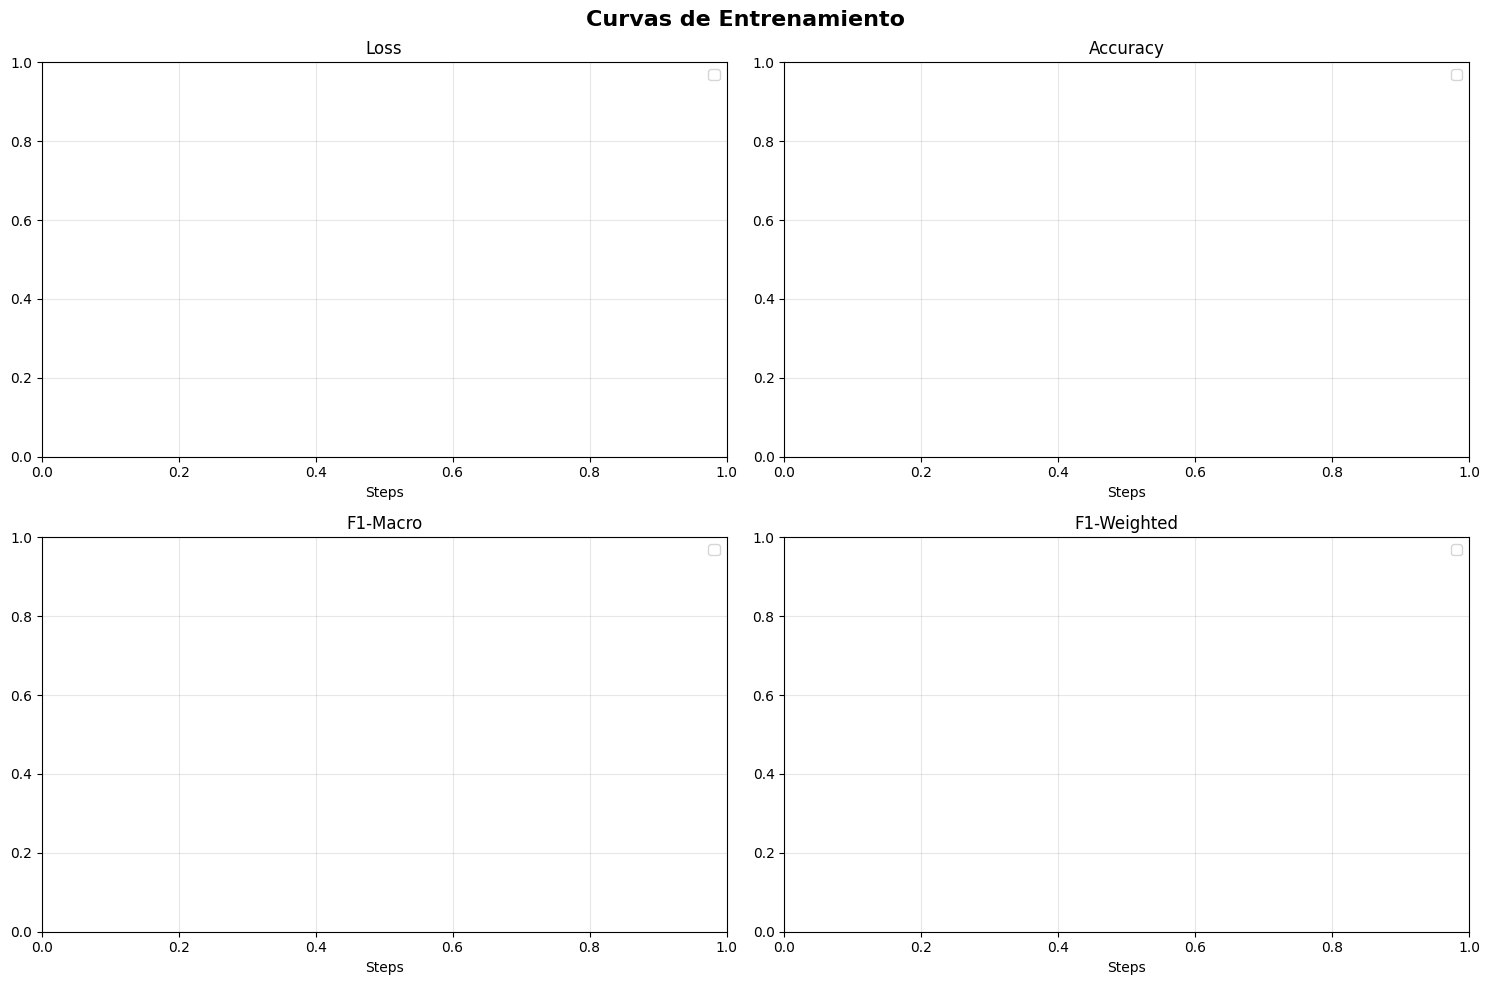

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Gradient checkpointing habilitado


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Mejor modelo cargado: sentiment-xlmr-epoch=02-val_f1_macro=0.629-v1.ckpt
ANÁLISIS DE RENDIMIENTO DEL MODELO
Resultados en Test Set:
  Test Loss: 0.6839
  Test Accuracy: 70.9%
  Test F1-Macro: 0.6800
  Test F1-Weighted: 0.8375

Reporte de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.91      0.85      0.88        71
      Neutro       0.50      0.50      0.50         6
    Positivo       0.78      0.87      0.82        45

    accuracy                           0.84       122
   macro avg       0.73      0.74      0.73       122
weighted avg       0.84      0.84      0.84       122

Matriz de confusión guardada: ../artifacts/plots/confusion_matrix.png


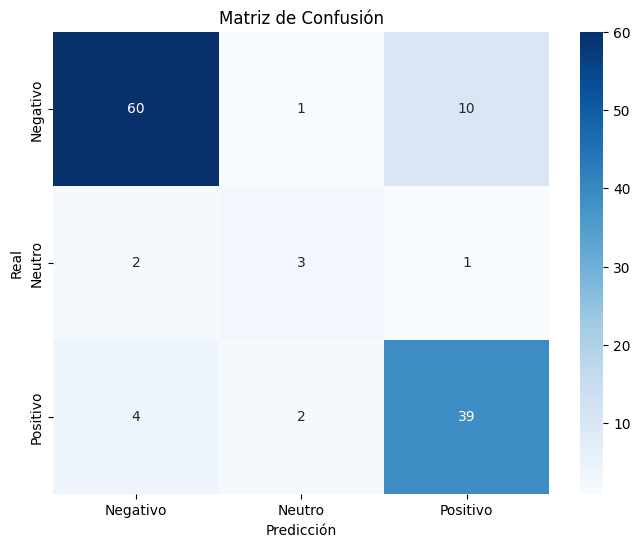

VALIDACIÓN CON EJEMPLOS MANUALES


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Gradient checkpointing habilitado
Modelo cargado desde checkpoint: sentiment-xlmr-epoch=02-val_f1_macro=0.629-v1.ckpt

Categoría: Muy Positivos
--------------------------------------------------
CORRECTO  1. Positivo  (36.3%) - ¡Excelente producto! Lo recomiendo totalmente, superó mis ex...
CORRECTO  2. Positivo  (38.1%) - Amazing service! I'm completely satisfied with my purchase
CORRECTO  3. Positivo  (44.6%) - Outstanding quality and fast delivery. Five stars!
ERROR  4. Neutro  (35.1%) - Me encanta este lugar, la comida está deliciosa y el servici...
ERROR  5. Neutro  (57.2%) - This is exactly what I was looking for. Brilliant!

Precisión en Muy Positivos: 3/5 (60.0%)

Categoría: Negativos
--------------------------------------------------
CORRECTO  1. Negativo  (40.8%) - Terrible experiencia, no lo recomiendo para nada. Muy decepc...
CORRECTO  2. Negativo  (44.8%) - Awful product, waste of money. Poor quality and bad customer...
CORRECTO  3. Negativo  (44.7%) - No funcionó como esp

In [59]:
# ============================================================
# ANÁLISIS POST-ENTRENAMIENTO COMPLETO
# ============================================================

def plot_training_curves(trainer):
    """Genera gráficas de las curvas de entrenamiento"""
    if not hasattr(trainer, 'logged_metrics') or not trainer.logged_metrics:
        print("No hay métricas de entrenamiento disponibles")
        return
    
    # Extraer métricas
    metrics = trainer.logged_metrics
    steps = list(range(len(metrics)))
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle("Curvas de Entrenamiento", fontsize=16, fontweight='bold')
    
    # Loss
    if 'train_loss' in metrics:
        axes[0,0].plot(steps, [m.get('train_loss', 0) for m in metrics.values()], 'b-', label='Train')
    if 'val_loss' in metrics:
        axes[0,0].plot(steps, [m.get('val_loss', 0) for m in metrics.values()], 'r-', label='Validation')
    axes[0,0].set_title('Loss')
    axes[0,0].set_xlabel('Steps')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Accuracy
    if 'train_acc' in metrics:
        axes[0,1].plot(steps, [m.get('train_acc', 0) for m in metrics.values()], 'b-', label='Train')
    if 'val_acc' in metrics:
        axes[0,1].plot(steps, [m.get('val_acc', 0) for m in metrics.values()], 'r-', label='Validation')
    axes[0,1].set_title('Accuracy')
    axes[0,1].set_xlabel('Steps')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # F1-macro
    if 'train_f1_macro' in metrics:
        axes[1,0].plot(steps, [m.get('train_f1_macro', 0) for m in metrics.values()], 'b-', label='Train')
    if 'val_f1_macro' in metrics:
        axes[1,0].plot(steps, [m.get('val_f1_macro', 0) for m in metrics.values()], 'r-', label='Validation')
    axes[1,0].set_title('F1-Macro')
    axes[1,0].set_xlabel('Steps')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # F1-weighted
    if 'train_f1_weighted' in metrics:
        axes[1,1].plot(steps, [m.get('train_f1_weighted', 0) for m in metrics.values()], 'b-', label='Train')
    if 'val_f1_weighted' in metrics:
        axes[1,1].plot(steps, [m.get('val_f1_weighted', 0) for m in metrics.values()], 'r-', label='Validation')
    axes[1,1].set_title('F1-Weighted')
    axes[1,1].set_xlabel('Steps')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Guardar
    plot_path = CFG.PLOTS_DIR / "training_curves.png"
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f"Gráficas de entrenamiento guardadas: {plot_path}")
    plt.show()

def analyze_model_performance(model, dm, class_names=['Negativo', 'Neutro', 'Positivo']):
    """Análisis detallado del rendimiento del modelo"""
    print("ANÁLISIS DE RENDIMIENTO DEL MODELO")
    print("="*50)
    
    model.eval()
    
    # Evaluar en test set
    trainer = pl.Trainer(
        accelerator=CFG.accelerator,
        devices=1,
        enable_progress_bar=False,
        logger=False
    )
    
    test_results = trainer.test(model, datamodule=dm, verbose=False)
    
    # Obtener predicciones detalladas
    all_preds = []
    all_labels = []
    all_probs = []
    
    model.to(CFG.device)
    
    with torch.no_grad():
        for batch in dm.test_dataloader():
            inputs, labels = batch
            inputs = {k: v.to(CFG.device) for k, v in inputs.items()}
            labels = labels.to(CFG.device)
            
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)
            preds = torch.argmax(outputs.logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Métricas generales
    print(f"Resultados en Test Set:")
    for result in test_results:
        print(f"  Test Loss: {result['test_loss']:.4f}")
        print(f"  Test Accuracy: {result['test_acc']:.1%}")
        print(f"  Test F1-Macro: {result['test_f1_macro']:.4f}")
        print(f"  Test F1-Weighted: {result['test_f1_weighted']:.4f}")
    
    # Classification Report
    print(f"\nReporte de Clasificación:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)
    
    # Visualizar matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    
    # Guardar
    cm_path = CFG.PLOTS_DIR / "confusion_matrix.png"
    plt.savefig(cm_path, dpi=150, bbox_inches='tight')
    print(f"Matriz de confusión guardada: {cm_path}")
    plt.show()
    
    return {
        'test_results': test_results,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs,
        'confusion_matrix': cm
    }

class SentimentInferencePipeline:
    """Pipeline optimizado para inferencia de sentimientos"""
    
    def __init__(self, checkpoint_path, tokenizer):
        self.tokenizer = tokenizer
        
        # Cargar modelo
        if checkpoint_path and Path(checkpoint_path).exists():
            self.model = SentimentClassifier.load_from_checkpoint(
                checkpoint_path, 
                map_location=CFG.device,
                strict=False
            )
            print(f"Modelo cargado desde checkpoint: {Path(checkpoint_path).name}")
        else:
            self.model = model  # Usar modelo actual
            print("Usando modelo actual (no se encontró checkpoint)")
        
        self.model.eval()
        self.model.to(CFG.device)
        
        # Mapeo de etiquetas
        self.label_map = {0: 'Negativo', 1: 'Neutro', 2: 'Positivo'}
        self.emoji_map = {0: '', 1: '', 2: ''}  # Sin emojis
        
    def predict_single(self, text):
        """Predice el sentimiento de un texto individual"""
        if not isinstance(text, str) or not text.strip():
            return {
                'prediction': 'Neutro',
                'confidence': 0.33,
                'probabilities': [0.33, 0.34, 0.33],
                'emoji': ''
            }
        
        # Tokenizar
        inputs = self.tokenizer(
            text.strip(),
            truncation=True,
            max_length=CFG.MAX_LEN,
            padding=True,
            return_tensors="pt"
        )
        
        # Mover a device
        inputs = {k: v.to(CFG.device) for k, v in inputs.items()}
        
        # Inferencia
        with torch.no_grad():
            outputs = self.model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)[0]
            pred_id = torch.argmax(probs).item()
        
        return {
            'prediction': self.label_map[pred_id],
            'confidence': float(probs[pred_id]),
            'probabilities': probs.cpu().numpy().tolist(),
            'emoji': self.emoji_map[pred_id]
        }
    
    def predict_batch(self, texts, batch_size=32):
        """Predice el sentimiento de un lote de textos"""
        if not texts:
            return []
        
        results = []
        
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            
            # Tokenizar batch
            inputs = self.tokenizer(
                batch_texts,
                truncation=True,
                max_length=CFG.MAX_LEN,
                padding=True,
                return_tensors="pt"
            )
            
            # Mover a device
            inputs = {k: v.to(CFG.device) for k, v in inputs.items()}
            
            # Inferencia
            with torch.no_grad():
                outputs = self.model(**inputs)
                probs = torch.softmax(outputs.logits, dim=1)
                pred_ids = torch.argmax(probs, dim=1)
            
            # Procesar resultados del batch
            for j, (text, pred_id, prob_vec) in enumerate(zip(batch_texts, pred_ids, probs)):
                results.append({
                    'text': text,
                    'prediction': self.label_map[pred_id.item()],
                    'confidence': float(prob_vec[pred_id]),
                    'probabilities': prob_vec.cpu().numpy().tolist(),
                    'emoji': self.emoji_map[pred_id.item()]
                })
        
        return results

def validate_with_examples(pipeline):
    """Valida el modelo con ejemplos manuales cuidadosamente seleccionados"""
    
    test_examples = {
        "Muy Positivos": [
            "¡Excelente producto! Lo recomiendo totalmente, superó mis expectativas",
            "Amazing service! I'm completely satisfied with my purchase",
            "Outstanding quality and fast delivery. Five stars!",
            "Me encanta este lugar, la comida está deliciosa y el servicio es perfecto",
            "This is exactly what I was looking for. Brilliant!"
        ],
        "Negativos": [
            "Terrible experiencia, no lo recomiendo para nada. Muy decepcionante",
            "Awful product, waste of money. Poor quality and bad customer service",
            "No funcionó como esperaba. Muy frustrante y confuso",
            "Worst purchase ever. Completely useless and overpriced",
            "Pésima atención al cliente, no resuelven ningún problema"
        ],
        "Neutrales": [
            "El producto llegó en la fecha indicada y cumple su función básica",
            "Standard quality product. Nothing special but does the job",
            "Funciona como se describe, sin más. Precio normal para lo que ofrece",
            "Received the item as described. Average experience overall",
            "Es un producto normal, ni bueno ni malo. Cumple expectativas básicas"
        ]
    }
    
    print("VALIDACIÓN CON EJEMPLOS MANUALES")
    print("="*50)
    
    # Cargar mejor checkpoint si existe
    best_checkpoint = training_results.get('best_path')
    pipeline = SentimentInferencePipeline(best_checkpoint, tokenizer)
    
    # Ejecutar validación
    validation_results = {}
    
    for category, examples in test_examples.items():
        print(f"\nCategoría: {category}")
        print("-" * 50)
        
        category_results = []
        correct_predictions = 0
        
        # Mapeo esperado
        expected_sentiment = {
            "Muy Positivos": "Positivo",
            "Negativos": "Negativo", 
            "Neutrales": "Neutro"
        }[category]
        
        for i, example in enumerate(examples, 1):
            result = pipeline.predict_single(example)
            is_correct = result['prediction'] == expected_sentiment
            correct_predictions += is_correct
            
            # Mostrar resultado
            status = "CORRECTO" if is_correct else "ERROR"
            print(f"{status} {i:2d}. {result['prediction']} {result['emoji']} "
                  f"({result['confidence']:.1%}) - {example[:60]}{'...' if len(example) > 60 else ''}")
            
            category_results.append({
                'text': example,
                'expected': expected_sentiment,
                'predicted': result['prediction'],
                'correct': is_correct,
                'confidence': result['confidence'],
                'probabilities': result['probabilities']
            })
        
        accuracy = correct_predictions / len(examples)
        print(f"\nPrecisión en {category}: {correct_predictions}/{len(examples)} ({accuracy:.1%})")
        
        validation_results[category] = {
            'examples': category_results,
            'accuracy': accuracy,
            'correct_count': correct_predictions,
            'total_count': len(examples)
        }
    
    # Resumen general
    total_correct = sum(v['correct_count'] for v in validation_results.values())
    total_examples = sum(v['total_count'] for v in validation_results.values())
    overall_accuracy = total_correct / total_examples
    
    print(f"\nRESUMEN GENERAL DE VALIDACIÓN")
    print("="*40)
    print(f"Total correcto: {total_correct}/{total_examples}")
    print(f"Precisión general: {overall_accuracy:.1%}")
    
    if overall_accuracy >= 0.8:
        print("Excelente rendimiento en validación manual!")
    elif overall_accuracy >= 0.7:
        print("Buen rendimiento, pero hay espacio para mejora")
    else:
        print("El modelo necesita más entrenamiento o ajustes")
    
    # Guardar resultados de validación
    validation_path = CFG.ARTIFACTS_DIR / "manual_validation_results.json"
    with open(validation_path, 'w', encoding='utf-8') as f:
        json.dump({
            'validation_results': validation_results,
            'overall_accuracy': overall_accuracy,
            'total_correct': total_correct,
            'total_examples': total_examples,
            'timestamp': datetime.now().isoformat(),
            'model_checkpoint': str(best_checkpoint) if best_checkpoint else "current_model"
        }, f, indent=2, ensure_ascii=False)
    
    print(f"Resultados guardados: {validation_path}")
    
    return pipeline, validation_results

# ============================================================
# EJECUTAR ANÁLISIS COMPLETO
# ============================================================

# 1. Generar curvas de entrenamiento
plot_training_curves(training_results['trainer'])

# 2. Cargar mejor modelo para evaluación
best_model_path = training_results['best_path']
if best_model_path and Path(best_model_path).exists():
    best_model = SentimentClassifier.load_from_checkpoint(best_model_path, class_weights=CLASS_WEIGHTS)
    print(f"Mejor modelo cargado: {Path(best_model_path).name}")
else:
    best_model = model
    print("Usando modelo actual (checkpoint no encontrado)")

best_model.eval()

# 3. Evaluación detallada
performance_results = analyze_model_performance(best_model, dm)

# 4. Validación con ejemplos manuales
pipeline, validation_results = validate_with_examples(None)

print("INICIANDO ANÁLISIS POST-ENTRENAMIENTO")
print("Análisis completo finalizado. Revisa las gráficas y métricas generadas.")